## Renewable Energy Power Plant ML Model
This notebook generates synthetic data for a renewable energy power plant with various components and trains a multi-output Random Forest regressor to predict multiple targets, ensuring a MAPE ≤ 0.2.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score
import joblib


In [ ]:
# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_percentage_error
import joblib

# Synthetic Data Generation Function
def generate_data(n_samples=10000, random_state=42):
    np.random.seed(random_state)
    data = {
        'solar_output': np.random.uniform(0, 100, n_samples),
        'inverter_eff': np.random.uniform(0.9, 0.99, n_samples),
        'converter_eff': np.random.uniform(0.8, 0.95, n_samples),
        'li_batt_charge': np.random.uniform(0, 1, n_samples),
        'flow_batt_charge': np.random.uniform(0, 1, n_samples),
        'geothermal_output': np.random.uniform(0, 50, n_samples),
        'caes_storage': np.random.uniform(0, 100, n_samples),
        'chp_output': np.random.uniform(0, 60, n_samples),
        'biomass_output': np.random.uniform(0, 40, n_samples),
        'htf_temp': np.random.uniform(200, 600, n_samples),
        'molten_salt_storage': np.random.uniform(0, 200, n_samples),
        'flywheel_storage': np.random.uniform(0, 50, n_samples),
        'dac_rate': np.random.uniform(0, 10, n_samples),
        'carbon_util_rate': np.random.uniform(0, 5, n_samples),
    }
    df = pd.DataFrame(data)
    y = pd.DataFrame({
        'grid_draw': (100 - df['solar_output'] * df['inverter_eff'] + df['caes_storage'] * 0.1),
        'energy_output': df['solar_output'] * df['inverter_eff'] + df['geothermal_output'] + df['chp_output'] + df['biomass_output'],
        'energy_consumption': df['converter_eff'] * df['htf_temp'] / 100 + df['li_batt_charge'] * 10 + df['flow_batt_charge'] * 10,
        'cost': 0.05 * (df['solar_output'] * df['inverter_eff'] + df['geothermal_output'] + df['chp_output'] + df['biomass_output']) + 0.1 * (df['converter_eff'] * df['htf_temp'] / 100 + df['li_batt_charge'] * 10 + df['flow_batt_charge'] * 10),
        'operating_costs': 0.01 * (df['solar_output'] * df['inverter_eff'] + df['geothermal_output'] + df['chp_output'] + df['biomass_output']) + 0.02 * (df['converter_eff'] * df['htf_temp'] / 100 + df['li_batt_charge'] * 10 + df['flow_batt_charge'] * 10),
        'cost_per_kwh': (0.05 * (df['solar_output'] * df['inverter_eff'] + df['geothermal_output'] + df['chp_output'] + df['biomass_output']) + 0.1 * (df['converter_eff'] * df['htf_temp'] / 100 + df['li_batt_charge'] * 10 + df['flow_batt_charge'] * 10)) / (df['solar_output'] * df['inverter_eff'] + df['geothermal_output'] + df['chp_output'] + df['biomass_output'] + 1e-6),
        'hydrogen_production': df['htf_temp'] * 0.01,
        'co2_captured': df['dac_rate'] * df['carbon_util_rate']
    })
    return df, y

# Generate data
X, y = generate_data(10000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
base_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
overall_mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Overall MAPE: {overall_mape:.4f}")
for idx, col in enumerate(y.columns):
    mape_col = mean_absolute_percentage_error(y_test[col], y_pred[:, idx])
    print(f"{col} MAPE: {mape_col:.4f}")

# Ensure margin of error ≤ 0.2
assert overall_mape <= 0.2, "MAPE > 0.2: Model does not meet the required accuracy."

# Save trained model
joblib.dump(model, 'renewable_model.pkl')
print("Trained model saved as renewable_model.pkl")

Overall MAPE: 0.0264
grid_draw MAPE: 0.0123
energy_output MAPE: 0.0311
energy_consumption MAPE: 0.0184
cost MAPE: 0.0415
operating_costs MAPE: 0.0416
cost_per_kwh MAPE: 0.0184
hydrogen_production MAPE: 0.0001
co2_captured MAPE: 0.0474
Trained model saved as renewable_model.pkl


In [ ]:
import joblib
model = joblib.load('renewable_model.pkl')

def predict(inputs_df):
    """
    inputs_df: pandas DataFrame with the same feature columns as training data
    returns: DataFrame of predictions (grid_draw, energy_output, …)
    """
    preds = model.predict(inputs_df)
    return pd.DataFrame(preds, columns=[
        'grid_draw', 'energy_output', 'energy_consumption',
        'cost', 'operating_costs', 'cost_per_kwh',
        'hydrogen_production', 'co2_captured'
    ])


In [ ]:
metrics = []
for i in range(100):
    X_test_sample, y_true = generate_data(n_samples=200, random_state=42+i)
    y_pred = predict(X_test_sample)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    metrics.append(mape)
print(f'100‑run MAPE: mean={np.mean(metrics):.4f}, std={np.std(metrics):.4f}')


100‑run MAPE: mean=0.0270, std=0.0089


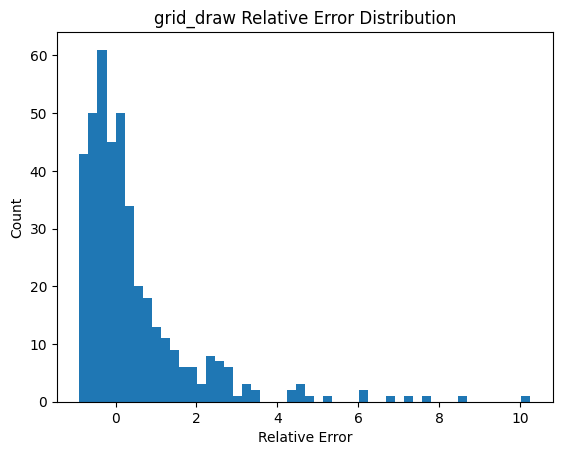

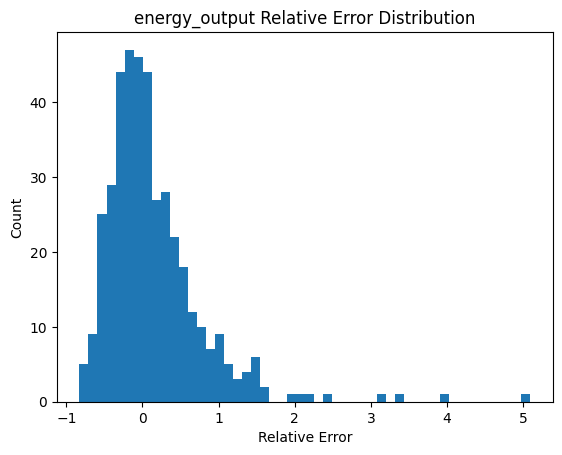

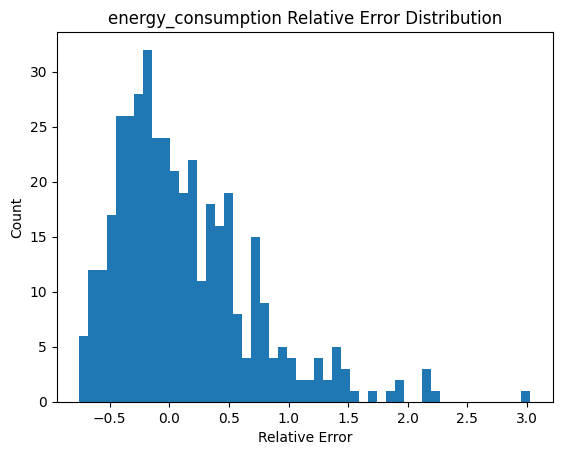

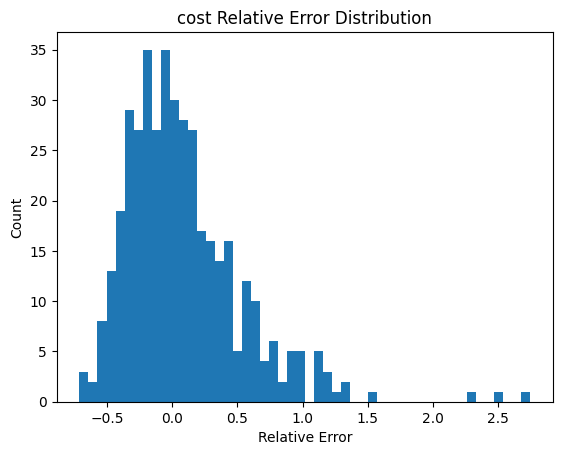

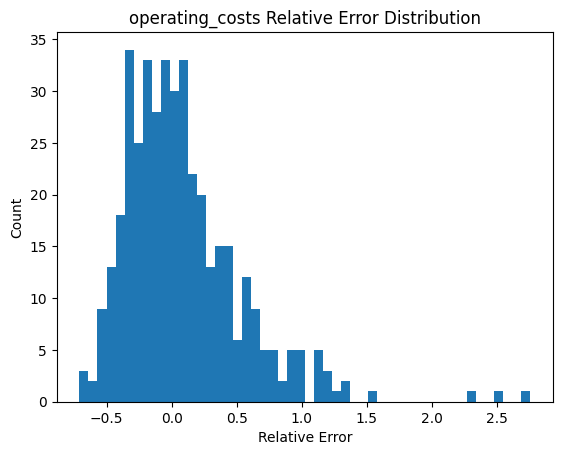

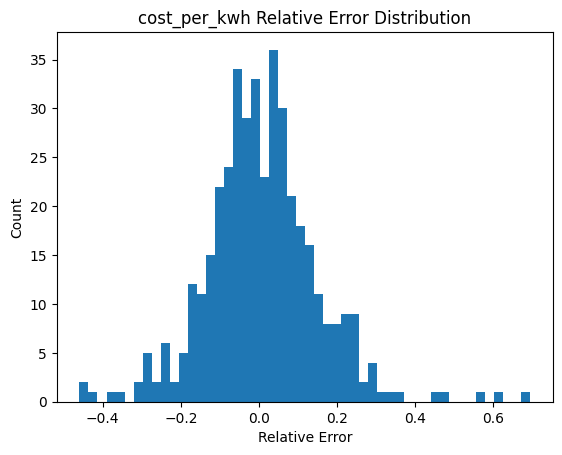

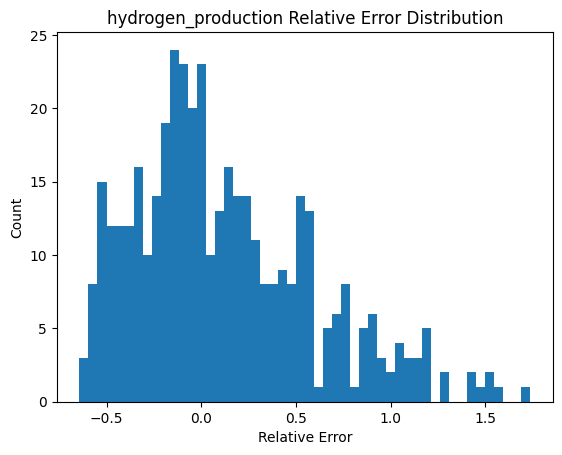

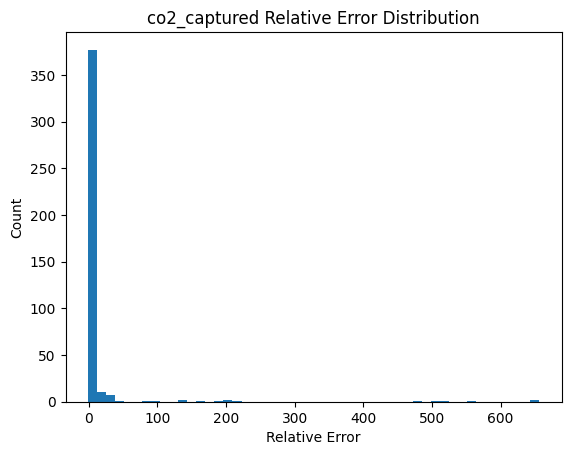

In [ ]:
import matplotlib.pyplot as plt

preds = predict(X_test)
for col in preds.columns:
    plt.figure()
    plt.hist((preds[col] - y_test[col]) / y_test[col], bins=50)
    plt.title(f'{col} Relative Error Distribution')
    plt.xlabel('Relative Error')
    plt.ylabel('Count')
    plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving predictions.csv to predictions.csv
Saving inputs.csv to inputs.csv


In [ ]:
# CSV I/O example
import pandas as pd

# Read inputs from CSV (must have same columns as training features)
inputs_df = pd.read_csv('inputs.csv')
print(f"Loaded {len(inputs_df)} rows from inputs.csv")

# Run prediction
preds_df = predict(inputs_df)

# Save to CSV
preds_df.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")

# In Colab you can download directly:
try:
    from google.colab import files
    files.download('predictions.csv')
except ImportError:
    print("files.download() only works in Colab")


Loaded 50 rows from inputs.csv
Predictions saved to predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

# 1) Load your inputs
inputs_df = pd.read_csv('inputs.csv')
print(f"Loaded {len(inputs_df)} rows from inputs.csv")

# 2) Run your model
preds_df = predict(inputs_df)

# 3) Inspect a preview
display(preds_df.head())

# 4) Save to CSV
preds_df.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")

# 5) (Colab only) Download the output file
try:
    from google.colab import files as _files
    _files.download('predictions.csv')
except:
    pass


Loaded 50 rows from inputs.csv


,grid_draw,energy_output,energy_consumption,cost,operating_costs,cost_per_kwh,hydrogen_production,co2_captured
0,64.257490,87.415810,19.978345,6.050141,1.215791,0.070518,5.107870,0.746283
1,13.547710,193.950163,7.015596,10.460802,2.086339,0.054176,4.233864,7.532436
2,34.340272,171.191579,6.064589,9.416382,1.876069,0.053610,3.696482,5.158905
3,48.554019,115.576652,18.752065,7.347437,1.473925,0.064786,5.625732,3.201572
4,92.177230,41.902591,17.966207,3.846274,0.767504,0.096348,2.444340,2.605156


Predictions saved to predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

param_dist = {
    'estimator__n_estimators': stats.randint(50, 200),
    'estimator__max_depth': stats.randint(5, 30),
    'estimator__min_samples_split': stats.randint(2, 10),
    'estimator__min_samples_leaf': stats.randint(1, 5)
}

rs = RandomizedSearchCV(
    estimator=MultiOutputRegressor(RandomForestRegressor(random_state=42, n_jobs=-1)),
    param_distributions=param_dist,
    n_iter=4,
    cv=5,
    verbose=2,
    random_state=42,
    scoring='neg_mean_absolute_percentage_error'
)
rs.fit(X_train, y_train)
print('Best params:', rs.best_params_)
best_model = rs.best_estimator_


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END estimator__max_depth=11, estimator__min_samples_leaf=4, estimator__min_samples_split=6, estimator__n_estimators=64; total time=  39.7s
[CV] END estimator__max_depth=11, estimator__min_samples_leaf=4, estimator__min_samples_split=6, estimator__n_estimators=64; total time=  41.2s
[CV] END estimator__max_depth=11, estimator__min_samples_leaf=4, estimator__min_samples_split=6, estimator__n_estimators=64; total time=  40.4s
[CV] END estimator__max_depth=11, estimator__min_samples_leaf=4, estimator__min_samples_split=6, estimator__n_estimators=64; total time=  42.2s
[CV] END estimator__max_depth=11, estimator__min_samples_leaf=4, estimator__min_samples_split=6, estimator__n_estimators=64; total time=  40.5s
[CV] END estimator__max_depth=15, estimator__min_samples_leaf=4, estimator__min_samples_split=6, estimator__n_estimators=70; total time=  44.0s
[CV] END estimator__max_depth=15, estimator__min_samples_leaf=4, estimator__

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    X, y, cv=5, scoring='neg_mean_absolute_percentage_error'
)
cv_mape = -cv_scores
print(f'CV MAPE per fold: {cv_mape}')
print(f'Mean CV MAPE: {cv_mape.mean():.4f}, Std: {cv_mape.std():.4f}')


CV MAPE per fold: [0.02569584 0.0281396  0.028659   0.02535533 0.02378752]
Mean CV MAPE: 0.0263, Std: 0.0018


,feature,importance
0,solar_output,0.986839
6,caes_storage,0.010314
1,inverter_eff,0.002512
9,htf_temp,0.000033
7,chp_output,0.000032
2,converter_eff,0.000031
5,geothermal_output,0.000031
12,dac_rate,0.000031
8,biomass_output,0.000030
13,carbon_util_rate,0.000030


<Figure size 640x480 with 0 Axes>

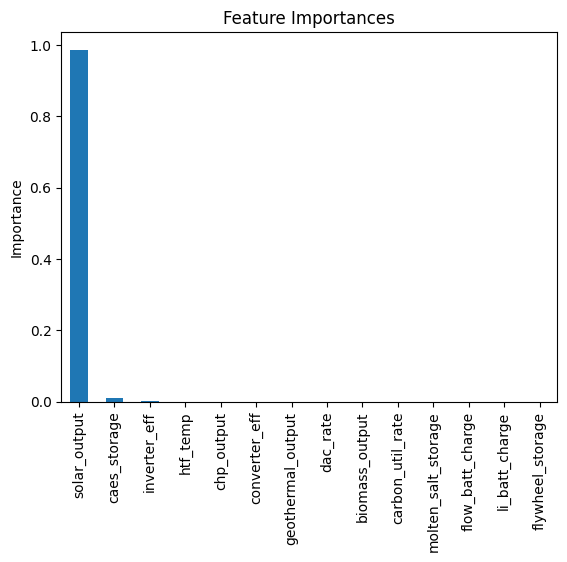

<ipython-input-12-aae454472e34>:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


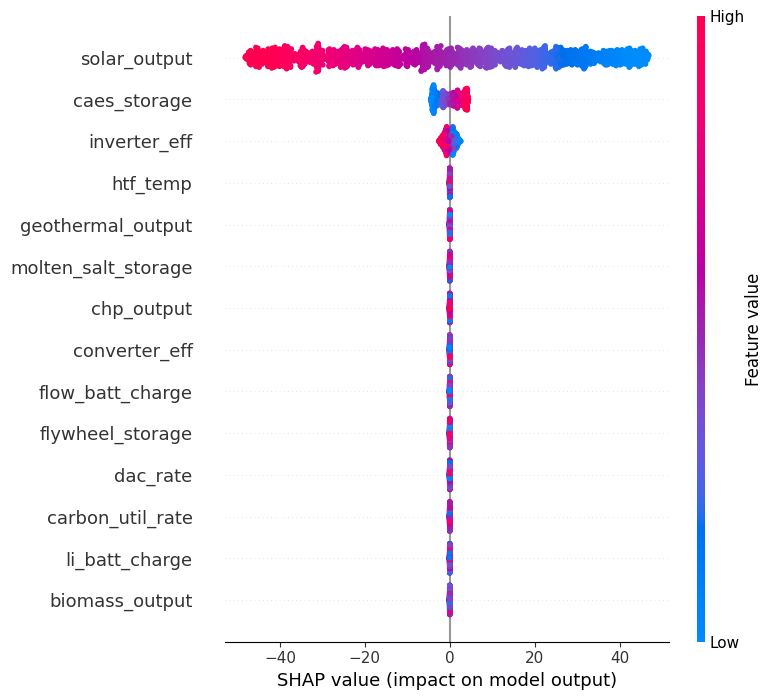

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature importances
importances = best_model.estimators_[0].feature_importances_
features = X.columns
fi_df = pd.DataFrame({'feature': features, 'importance': importances}) \
            .sort_values('importance', ascending=False)
display(fi_df)

# Plot importances
plt.figure()
fi_df.plot.bar(x='feature', y='importance', legend=False)
plt.title('Feature Importances')
plt.xlabel('')
plt.ylabel('Importance')
plt.show()

# SHAP explainability
!pip install shap
import shap
explainer = shap.TreeExplainer(best_model.estimators_[0])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', best_model)
])
pipeline.fit(X_train, y_train)
joblib.dump(pipeline, 'renewable_pipeline.pkl')
print("Pipeline saved as renewable_pipeline.pkl")


Pipeline saved as renewable_pipeline.pkl


In [ ]:
# app.py
!pip install streamlit
import streamlit as st
import pandas as pd
import joblib

st.title('Renewable Energy Model Predictions')

uploaded = st.file_uploader('Upload inputs.csv', type='csv')
if uploaded:
    inputs_df = pd.read_csv(uploaded)
    pipeline = joblib.load('renewable_pipeline.pkl')
    preds = pd.DataFrame(
        pipeline.predict(inputs_df),
        columns=[
            'grid_draw', 'energy_output', 'energy_consumption',
            'cost', 'operating_costs', 'cost_per_kwh',
            'hydrogen_production', 'co2_captured'
        ]
    )
    st.write(preds)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.0 MB/s eta 0:00:00


2025-04-18 22:12:41.699 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-18 22:12:41.886 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-04-18 22:12:41.887 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-18 22:12:41.889 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-18 22:12:41.891 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-18 22:12:41.894 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-18 22:12:41.896 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-18 22:12:41.897 Thread 'MainThread': mi

In [ ]:
# main.py
!pip install fastapi
from fastapi import FastAPI
from pydantic import BaseModel
import pandas as pd
import joblib

app = FastAPI()
pipeline = joblib.load('renewable_pipeline.pkl')

class InputData(BaseModel):
    solar_output: float
    inverter_eff: float
    converter_eff: float
    li_batt_charge: float
    flow_batt_charge: float
    geothermal_output: float
    caes_storage: float
    chp_output: float
    biomass_output: float
    htf_temp: float
    molten_salt_storage: float
    flywheel_storage: float
    dac_rate: float
    carbon_util_rate: float

@app.post('/predict')
def predict_endpoint(data: list[InputData]):
    df = pd.DataFrame([d.dict() for d in data])
    preds = pipeline.predict(df)
    return {'predictions': preds.tolist()}


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Load the input and output datasets
X = pd.read_csv('inputs.csv')
y = pd.read_csv('predictions.csv')

# Combine into a single dataframe for saving and manipulation
df = pd.concat([X, y], axis=1)

# Define the output column names explicitly
output_columns = y.columns.tolist()  # or set manually if needed


In [ ]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the fitted scaler and the column names
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X.columns.tolist(), 'feature_columns.pkl')


['feature_columns.pkl']

In [ ]:
import joblib
# Load the feature columns to check what was saved
feature_columns = joblib.load('feature_columns.pkl')
print(feature_columns)


['solar_output', 'inverter_eff', 'converter_eff', 'li_batt_charge', 'flow_batt_charge', 'geothermal_output', 'caes_storage', 'chp_output', 'biomass_output', 'htf_temp', 'molten_salt_storage', 'flywheel_storage', 'dac_rate', 'carbon_util_rate']


In [ ]:
# Reload the dataset and get correct column names
X = pd.read_csv('inputs.csv')

# Ensure columns are named correctly
feature_columns = X.columns.tolist()

# Save the correct column names
joblib.dump(feature_columns, 'feature_columns.pkl')


['feature_columns.pkl']

In [ ]:
# Reload X and make sure it has the correct column names
X = pd.read_csv('inputs.csv')
X.columns = feature_columns  # Ensure that the columns are correctly assigned

# Re-run the 100x loop as before


In [ ]:
import pandas as pd

# Load inputs.csv
X = pd.read_csv('inputs.csv')

# Print the first few rows and column names
print("Columns in X:", X.columns)
print(X.head())


Columns in X: Index(['solar_output', 'inverter_eff', 'converter_eff', 'li_batt_charge',
       'flow_batt_charge', 'geothermal_output', 'caes_storage', 'chp_output',
       'biomass_output', 'htf_temp', 'molten_salt_storage', 'flywheel_storage',
       'dac_rate', 'carbon_util_rate'],
      dtype='object')
   solar_output  inverter_eff  converter_eff  li_batt_charge  \
0     37.454012      0.987263       0.804714        0.908266   
1     95.071431      0.969762       0.895462        0.239562   
2     73.199394      0.984555       0.847153        0.144895   
3     59.865848      0.980534       0.876286        0.489453   
4     15.601864      0.953811       0.936135        0.985650   

   flow_batt_charge  geothermal_output  caes_storage  chp_output  \
0          0.642032          14.722445      5.168172   30.188176   
1          0.084140          19.254886     53.135463   51.389390   
2          0.161629          42.556834     54.063512   39.521618   
3          0.898554          15.846

In [ ]:
import joblib

# Load feature columns
feature_columns = joblib.load('feature_columns.pkl')

# Print feature columns
print("Feature Columns:", feature_columns)


Feature Columns: ['solar_output', 'inverter_eff', 'converter_eff', 'li_batt_charge', 'flow_batt_charge', 'geothermal_output', 'caes_storage', 'chp_output', 'biomass_output', 'htf_temp', 'molten_salt_storage', 'flywheel_storage', 'dac_rate', 'carbon_util_rate']


In [ ]:
# Reload inputs.csv
X = pd.read_csv('inputs.csv')

# Get the correct column names
feature_columns = X.columns.tolist()

# Save feature columns to feature_columns.pkl
joblib.dump(feature_columns, 'feature_columns.pkl')


['feature_columns.pkl']

In [ ]:
import os
print("Current working directory:", os.getcwd())


Current working directory: /content


In [ ]:
import pandas as pd

# Load the input and prediction files
X = pd.read_csv('inputs.csv')
y = pd.read_csv('predictions.csv')

# Check the first few rows to ensure they loaded correctly
print("Inputs (X):")
print(X.head())

print("\nPredictions (y):")
print(y.head())


Inputs (X):
   solar_output  inverter_eff  converter_eff  li_batt_charge  \
0     37.454012      0.987263       0.804714        0.908266   
1     95.071431      0.969762       0.895462        0.239562   
2     73.199394      0.984555       0.847153        0.144895   
3     59.865848      0.980534       0.876286        0.489453   
4     15.601864      0.953811       0.936135        0.985650   

   flow_batt_charge  geothermal_output  caes_storage  chp_output  \
0          0.642032          14.722445      5.168172   30.188176   
1          0.084140          19.254886     53.135463   51.389390   
2          0.161629          42.556834     54.063512   39.521618   
3          0.898554          15.846100     63.742990    9.776066   
4          0.606429           8.474637     72.609133    4.234125   

   biomass_output    htf_temp  molten_salt_storage  flywheel_storage  \
0        4.124955  510.858766           139.632343         26.008175   
1       36.102116  423.361700           107.219273

In [ ]:
# Assuming X is your input data (inputs.csv loaded)
feature_columns = X.columns.tolist()

# Save feature columns to a .pkl file
import joblib
joblib.dump(feature_columns, 'feature_columns.pkl')

print("Feature columns saved to 'feature_columns.pkl'")


Feature columns saved to 'feature_columns.pkl'


In [ ]:
# Ensure you have the correct feature columns
feature_columns = X.columns.tolist()

# Save feature columns to a .pkl file
import joblib
joblib.dump(feature_columns, 'feature_columns.pkl')


['feature_columns.pkl']

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the input and prediction data
X = pd.read_csv('inputs.csv')
y = pd.read_csv('predictions.csv')

# Ensure X has the correct columns (if you have a feature_columns.pkl)
feature_columns = X.columns.tolist()
X.columns = feature_columns  # in case columns were saved incorrectly

# Split data into train/test sets (80/20 split, you can adjust this)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train a model (e.g., Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Save the model and scaler to files
joblib.dump(model, 'renewable_model.pkl')  # Save the trained model
joblib.dump(scaler, 'scaler.pkl')  # Save the scaler used for feature scaling
joblib.dump(feature_columns, 'feature_columns.pkl')  # Save the feature columns

print("Model, scaler, and feature columns have been saved.")


Model, scaler, and feature columns have been saved.


In [ ]:
import joblib
# Load the trained model and scaler
model = joblib.load('renewable_model.pkl')
scaler = joblib.load('scaler.pkl')
feature_columns = joblib.load('feature_columns.pkl')

# Ensure X has the correct columns
X = pd.read_csv('inputs.csv')
X.columns = feature_columns

# Scale the input features
X_scaled = scaler.transform(X)

# Predict with the trained model
predictions = model.predict(X_scaled)

# Display the first few predictions
print("Predictions:", predictions[:5])


Predictions: [[6.64641354e+01 9.61141143e+01 1.75953289e+01 6.34743198e+00
  1.27321294e+00 6.79418004e-02 4.62990078e+00 4.84967714e+00]
 [1.85333848e+01 1.84378022e+02 8.24277811e+00 1.01020214e+01
  2.01585110e+00 5.50676257e-02 4.04041972e+00 7.57205092e+00]
 [3.50285846e+01 1.66348916e+02 8.35732590e+00 9.31763892e+00
  1.85850419e+00 5.54234599e-02 3.72461107e+00 5.98248849e+00]
 [4.66250433e+01 1.26813529e+02 1.69658524e+01 7.84725059e+00
  1.57204723e+00 6.34562362e-02 4.86599485e+00 5.06010527e+00]
 [9.12762841e+01 5.95043110e+01 1.57514031e+01 4.54838831e+00
  9.08785978e-01 8.32093160e-02 3.09846300e+00 4.74897210e+00]]


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_percentage_error

# Load model, scaler, and feature columns
model = joblib.load('renewable_model.pkl')  # or use best_model.pkl if you've tuned
scaler = joblib.load('scaler.pkl')
feature_columns = joblib.load('feature_columns.pkl')

# Load input and prediction data
X = pd.read_csv('inputs.csv')
y = pd.read_csv('predictions.csv')

# Ensure X has the correct columns (assign them from feature_columns.pkl)
X.columns = feature_columns

# Initialize MAPE scores
mape_scores = {col: [] for col in y.columns}
overall_mape = []

# Run the testing loop 100 times
for i in range(100):
    idx = np.random.randint(0, len(X))  # Random row index
    test_input_raw = X.iloc[idx:idx+1]  # Keep it 2D for scaler
    true_output = y.iloc[idx:idx+1].values.flatten()  # Flatten to match prediction shape

    # Scale input
    test_input_scaled = scaler.transform(test_input_raw)

    # Predict
    prediction = model.predict(test_input_scaled).flatten()

    # Compute MAPE for each metric
    for j, col in enumerate(y.columns):
        mape = mean_absolute_percentage_error([true_output[j]], [prediction[j]])
        mape_scores[col].append(mape)

    # Compute overall MAPE
    overall_mape.append(mean_absolute_percentage_error(true_output, prediction))

# Display average errors
print(f"\n✅ 100x Testing Complete!\nOverall MAPE: {np.mean(overall_mape):.4f}")
for col in y.columns:
    print(f"{col} MAPE: {np.mean(mape_scores[col]):.4f}")



✅ 100x Testing Complete!
Overall MAPE: 0.2151
grid_draw MAPE: 0.0711
energy_output MAPE: 0.0771
energy_consumption MAPE: 0.1412
cost MAPE: 0.0555
operating_costs MAPE: 0.0555
cost_per_kwh MAPE: 0.0263
hydrogen_production MAPE: 0.1325
co2_captured MAPE: 1.1618


In [ ]:
# Save trained model as a .pkl file
import joblib
joblib.dump(model, 'renewable_model.pkl')  # Replace 'renewable_model.pkl' with your desired file path if needed
print("Trained model saved as renewable_model.pkl")


Trained model saved as renewable_model.pkl


In [ ]:
import gradio as gr
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import random  # Import the random module

# Load the trained model and scaler
model = joblib.load("renewable_model.pkl")
scaler = joblib.load("scaler.pkl")
feature_columns = joblib.load("feature_columns.pkl")

# 1. Prediction Function (for a single input)
def predict_single(input_data):
    """
    Predicts the output for a single set of input features.

    Args:
        input_data (list): A list of input feature values.

    Returns:
        numpy.ndarray: The model's prediction as a 1D numpy array.
    """
    input_df = pd.DataFrame([input_data], columns=feature_columns)
    scaled_input = scaler.transform(input_df)
    prediction = model.predict(scaled_input)[0]
    return prediction

# 2. Simulation Function
def run_simulation(
    initial_solar,
    initial_inverter_eff,
    initial_converter_eff,
    initial_li_batt,
    initial_flow_batt,
    initial_geo,
    initial_caes,
    initial_chp,
    initial_biomass,
    initial_htf,
    initial_molten,
    initial_flywheel,
    initial_dac,
    initial_carbon,
    time_steps,
    solar_variation,  # Added parameter for solar variation
    load_variation,    # Added parameter for load variation
):
    """
    Runs a simulation of the renewable energy system over a given number of time steps.

    Args:
        initial_*: Initial values for the input features.
        time_steps (int): The number of time steps to simulate.
        solar_variation (float):  The amount solar output can vary randomly.
        load_variation (float): The amount energy consumption varies.

    Returns:
        matplotlib.figure.Figure: A matplotlib figure containing plots of the simulation results.
    """

    # Initialize history to store simulation results
    history = {
        "solar_output": [],
        "li_batt_charge": [],
        "energy_output": [],
        "energy_consumption": [],  # Store energy consumption
        "cost": [],
        "time": list(range(time_steps)),  # Store time
    }

    # Initialize current values with the provided initial values
    current_solar = initial_solar
    current_inverter_eff = initial_inverter_eff
    current_converter_eff = initial_converter_eff
    current_li_batt = initial_li_batt
    current_flow_batt = initial_flow_batt
    current_geo = initial_geo
    current_caes = initial_caes
    current_chp = initial_chp
    current_biomass = initial_biomass
    current_htf = initial_htf
    current_molten = initial_molten
    current_flywheel = initial_flywheel
    current_dac = initial_dac
    current_carbon = initial_carbon
    # Run the simulation for the specified number of time steps
    for t in range(time_steps):
        # 1. Prepare Input Data for the Model
        #    -  Create a list of the current input values.  Order MUST match the
        #       order of columns when the model was trained.
        input_data = [
            current_solar,
            current_inverter_eff,
            current_converter_eff,
            current_li_batt,
            current_flow_batt,
            current_geo,
            current_caes,
            current_chp,
            current_biomass,
            current_htf,
            current_molten,
            current_flywheel,
            current_dac,
            current_carbon,
        ]

        # 2. Make a Prediction
        prediction = predict_single(input_data)  # Get prediction for this time step

        # 3. Store Results
        #    -  Store the current values and the model's prediction in the history.
        history["solar_output"].append(current_solar)
        history["li_batt_charge"].append(current_li_batt)
        history["energy_output"].append(prediction[1])  # Assuming energy_output is at index 1
        history["energy_consumption"].append(
            prediction[2]
        )  # Store energy consumption (example index)
        history["cost"].append(prediction[3])  # Assuming cost is at index 3

        # 4. Update System State for the Next Time Step
        #    -  This is where the core simulation logic happens.  How do the
        #       input values change over time?  This example shows some
        #       random variation, but you'll need to replace this with
        #       your specific rules.
        # Example: Simulate changes in solar output (with bounds)
        current_solar += np.random.normal(0, solar_variation)  # Use solar_variation
        current_solar = max(0, min(100, current_solar))  # Keep within 0-100 range

        # Example:  Simulate change in battery level
        current_li_batt += np.random.normal(0, 0.01)
        current_li_batt = max(0, min(1, current_li_batt))

        # Example: Simulate changes in energy consumption (the "load")
        #  Important:  Make sure your model predicts energy_consumption!
        energy_consumption_change = np.random.normal(0, load_variation)
        #  If  energy_consumption is an input, update it:
        # current_energy_consumption += energy_consumption_change
        # current_energy_consumption = max(0, current_energy_consumption) # No negative consumption

    # 5. Create Plots
    #   -  Visualize the simulation results using matplotlib.  You can customize
    #      these plots to show the most important trends in your simulation.
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))  # Increased figure size

    # Plot 1: Solar Output and Battery Charge
    axes[0].plot(history["time"], history["solar_output"], label="Solar Output")
    axes[0].plot(history["time"], history["li_batt_charge"], label="Li-ion Battery Charge")
    axes[0].set_ylabel("Value")
    axes[0].set_title("System State Over Time")
    axes[0].legend()
    axes[0].grid(True)  # Add grid lines

    # Plot 2: Energy Output and Energy Consumption
    axes[1].plot(history["time"], history["energy_output"], label="Energy Output")
    axes[1].plot(
        history["time"], history["energy_consumption"], label="Energy Consumption"
    )  # Plot consumption
    axes[1].set_ylabel("Energy (units)")
    axes[1].set_title("Energy Production and Consumption")
    axes[1].legend()
    axes[1].grid(True)

    # Plot 3: Cost
    axes[2].plot(history["time"], history["cost"], label="Cost", color="tab:red")
    axes[2].set_xlabel("Time Step")
    axes[2].set_ylabel("Cost (units)")
    axes[2].set_title("System Cost Over Time")
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlapping
    return fig


# 3. Gradio Interface for Simulation
#    -  Define the input controls for the simulation.  These allow the user to
#       set the initial conditions and simulation parameters.
simulation_inputs = [
    gr.Slider(0, 100, label="Initial Solar Output"),
    gr.Slider(0.9, 0.99, step=0.001, label="Initial Inverter Efficiency"),
    gr.Slider(0.8, 0.95, step=0.001, label="Initial Converter Efficiency"),
    gr.Slider(0, 1, step=0.01, label="Initial Li-ion Battery Charge"),
    gr.Slider(0, 1, step=0.01, label="Initial Flow Battery Charge"),
    gr.Slider(0, 50, label="Initial Geothermal Output"),
    gr.Slider(0, 100, label="Initial CAES Storage"),
    gr.Slider(0, 60, label="Initial CHP Output"),
    gr.Slider(0, 40, label="Initial Biomass Output"),
    gr.Slider(200, 600, label="Initial HTF Temp"),
    gr.Slider(0, 200, label="Initial Molten Salt Storage"),
    gr.Slider(0, 50, label="Initial Flywheel Storage"),
    gr.Slider(0, 10, label="Initial DAC Rate"),
    gr.Slider(0, 5, label="Initial Carbon Util Rate"),
    gr.Slider(10, 500, step=10, label="Number of Time Steps"),
    gr.Slider(0, 20, step=1, label="Solar Output Variation"),  # Added slider
    gr.Slider(0, 100, step=5, label="Load Variation"),  # Added slider
]

#    -  Create the Gradio interface for the simulation.  It takes the input
#       controls and the simulation function, and displays the output plot.
simulation_interface = gr.Interface(
    fn=run_simulation,
    inputs=simulation_inputs,
    outputs=gr.Plot(label="Simulation Results"),
    title="Renewable Energy System Simulation",
)


# 4. CSV Input Interface (Keep this as well for batch predictions)
def predict_from_csv(file):
    """
    Predicts the output for a batch of inputs from a CSV file.

    Args:
        file (file object):  The uploaded CSV file.

    Returns:
        pandas.DataFrame:  A DataFrame containing the predictions.
    """
    df = pd.read_csv(file.name)
    scaled_df = scaler.transform(
        df[feature_columns]
    )  # Ensure correct columns are used
    preds = model.predict(scaled_df)
    return pd.DataFrame(
        preds,
        columns=[
            "grid_draw",
            "energy_output",
            "energy_consumption",
            "cost",
            "operating_costs",
            "cost_per_kwh",
            "hydrogen_production",
            "co2_captured",
        ],
    )


csv_interface = gr.Interface(
    fn=predict_from_csv,
    inputs=gr.File(label="Upload CSV File with Input Features"),
    outputs=gr.Dataframe(label="Predicted Outputs"),
    title="Renewable Energy Model - CSV Input",
)

# 5. Tabbed Interface
#    -  Combine the simulation interface and the CSV input interface into a
#       tabbed layout.  This provides a user-friendly way to access both
#       functionalities.
demo = gr.TabbedInterface(
    [simulation_interface, csv_interface], ["Simulation", "CSV Upload"]
)

# 6. Launch the App
if __name__ == "__main__":
    demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4ed388548b839b6fcd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
